In [94]:
import pandas as pd
import sqlite3
import numpy as np
import plotly.graph_objects as go
import plotly.offline as offline
offline.init_notebook_mode(connected = True)

##**[P1] Conexión a nuestra BD y extracción de Información** 

In [3]:
conn = sqlite3.connect('problemas_seleccion.db')

In [4]:
df = pd.read_sql('SELECT * FROM TABLA_VENTAS WHERE TIENDA = 1 AND ID_CATEGORIA = 5', conn)

In [6]:
df

,TIENDA,ID_CATEGORIA,FECHA,VENTAS
0,1,5,2018-02-02 00:00:00,2636.000000
1,1,5,2018-05-16 00:00:00,818.000000
2,1,5,2019-05-22 00:00:00,910.000000
3,1,5,2018-10-11 00:00:00,1387.000000
4,1,5,2018-02-14 00:00:00,1137.000000
...,...,...,...,...
847,1,5,2018-10-13 00:00:00,3680.000000
848,1,5,2019-01-13 00:00:00,2447.000000
849,1,5,2018-12-23 00:00:00,8658.000000
850,1,5,2018-03-16 00:00:00,1672.000000


##**[P2] Descripción del problema**

En primera instancia debemos notar que estamos frente a un problema de forecasting de demanda, y por lo tanto lo natural es usar algún modelo como Arima, Sarimax o herramientas de regresión en caso de que estas entreguen un buen resultado. Para esto necesitaramos la mayor cantidad de data historica posible. 

Nosotros en esta primera propuesta probaremos con un modelo de regresión potente, el XGBoost y compararemos su resultado con una rápida y clásica implementación de una librería llamada FBprophet para series de tiempo. Para el primer modelo no asumimos ni estacionariedad ni normalidad de los errores como tampoco lags en nuestros datos y para el segunde si mostraremos su estacionariedad.

La metodología será una revisión rápida de la información para luego modelar el problema desde  el punto de vista de nuestros algoritmos escogidos y así finalmente poder entregar un estimado para las venta de carne en semanas posteriores según el algoritmo que nos entregue un resultado más aceptable.

##**[P3] Implementando nuestro modelo**

## **Primera revisión de los datos**

Inspeccionamos los tipos de variables dentro de nuestro df.

In [5]:
df.info(), df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 852 entries, 0 to 851
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   TIENDA        852 non-null    int64  
 1   ID_CATEGORIA  852 non-null    int64  
 2   FECHA         852 non-null    object 
 3   VENTAS        852 non-null    float64
dtypes: float64(1), int64(2), object(1)
memory usage: 26.8+ KB


(None,        TIENDA  ID_CATEGORIA        VENTAS
 count   852.0         852.0    852.000000
 mean      1.0           5.0   2287.154957
 std       0.0           0.0   1605.793504
 min       1.0           5.0    362.000000
 25%       1.0           5.0   1086.000000
 50%       1.0           5.0   1799.688996
 75%       1.0           5.0   3008.363742
 max       1.0           5.0  10878.000000)

Notamos que nuestra **columna FECHA** está en f**ormato de string**, entonces, lo ideal es transformarla a **Datetime** para poder trabajar nuestro Forecast. Además nos debemos deshacer de las columnas TIENDA e ID_CATEGORIA que en este momento no están aportando.

In [15]:
df['FECHA'] = pd.to_datetime(df['FECHA'])
df = df.drop(columns = ['TIENDA', 'ID_CATEGORIA'], axis = 1)
df.head()

,FECHA,VENTAS
0,2018-02-02,2636.0
1,2018-05-16,818.0
2,2019-05-22,910.0
3,2018-10-11,1387.0
4,2018-02-14,1137.0


Además, notemos que las fechas no están en orden, eso lo debemos ordenar a continuación:

In [16]:
df = df.sort_values(by='FECHA')
df = df.reset_index()


In [17]:
df = df.drop('index', axis = 1)

In [18]:
df.tail()

,FECHA,VENTAS
847,2019-12-11,1290.206994
848,2019-12-12,1387.618000
849,2019-12-13,2535.910981
850,2019-12-14,4388.873985
851,2019-12-15,3643.656030


## **Pequeña Exploración de los datos**
Para fines de exploración de los datos descompondremos la fecha:

In [10]:
df_exploratorio = df.copy()
df_exploratorio['dia'] = df_exploratorio.FECHA.map(lambda x: x.day)
df_exploratorio['mes'] = df_exploratorio.FECHA.map(lambda x: x.month)
df_exploratorio['anio'] = df_exploratorio.FECHA.map(lambda x: x.year)
df_exploratorio['week'] = df_exploratorio['FECHA'].dt.isocalendar().week
df_exploratorio['quarter'] = df_exploratorio['FECHA'].dt.quarter
df_exploratorio['day_of_week'] = df_exploratorio['FECHA'].dt.day_name()

Observemos como se ven los datos en primera instancia

In [11]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=df_exploratorio['FECHA'], y=df_exploratorio['VENTAS'], mode='lines', fill='tozeroy', fillcolor='#c6ccd8',
                     marker=dict(color= '#496595'), name='Ventas por Día'))
fig.update_layout(height=750, bargap=0.15,
                  margin=dict(b=0,r=20,l=20), 
                  title_text="Ventas por Día",
                  template="plotly_white",
                  title_font=dict(size=25, color='#8a8d93', family="Lato, sans-serif"),
                  font=dict(color='#8a8d93'),
                  hoverlabel=dict(bgcolor="#f2f2f2", font_size=13, font_family="Lato, sans-serif"),
                  showlegend=False)
fig.show()

A simple vista se pueden observar unos días de muchas ventas en comparación al resto. La hipotesis mas clara es que son las fiestas y feriados las causantes de estas anomalías pero intentemos dar un análisis más gráfico de estos fenómenos.

In [12]:
df_2017 = df_exploratorio[df_exploratorio['anio']==2017][['mes','VENTAS']]
df_2017 = df_2017.groupby('mes').agg({"VENTAS" : "mean"}).reset_index().rename(columns={'VENTAS':'s17'})
df_2018 = df_exploratorio[df_exploratorio['anio']==2018][['mes','VENTAS']]
df_2018 = df_2018.groupby('mes').agg({"VENTAS" : "mean"}).reset_index().rename(columns={'VENTAS':'s18'})
df_2019 = df_exploratorio[df_exploratorio['anio']==2019][['mes','VENTAS']]
df_2019 = df_2019.groupby('mes').agg({"VENTAS" : "mean"}).reset_index().rename(columns={'VENTAS':'s19'})

In [13]:
print(df_2017.shape, df_2018.shape,df_2019.shape)

(5, 2) (12, 2) (12, 2)


Observemos que el df_2017 tiene sólo los últimos 5 meses como dato, si la muestra hubiese tenido 7 o más meses hubiesemos podido reemplazar los meses faltantes con la media de los 7 meses, pero como no es el caso y solo para fines de visualización obviaremos este para tener un panorama más general.

In [14]:
df_year = df_2018.merge(df_2019,on='mes')


top_labels = ['2018', '2019']

colors = ['rgba(38, 24, 74, 0.8)', 'rgba(71, 58, 131, 0.8)']

# X axis value 
df_year = df_year[['s18','s19']].replace(np.nan,0)
x_data = df_year.values

# y axis value (Month)
df_2018['mes'] =['Ene','Feb','Mar','Abr','May','Jun','Jul','Ago','Sep','Oct','Nov','Dec']
y_data = df_2018['mes'].tolist()

fig = go.Figure()
for i in range(0, len(x_data[0])):
    for xd, yd in zip(x_data, y_data):
        fig.add_trace(go.Bar(
            x=[xd[i]], y=[yd],
            orientation='h',
            marker=dict(
                color=colors[i],
                line=dict(color='rgb(248, 248, 249)', width=1)
            )
        ))

fig.update_layout(title='Media de Ventas por año',
    xaxis=dict(showgrid=False, 
               zeroline=False, domain=[0.15, 1]),
    yaxis=dict(showgrid=False, showline=False,
               showticklabels=False, zeroline=False),
    barmode='stack', 
    template="plotly_white",
    margin=dict(l=0, r=50, t=100, b=10),
    showlegend=False, 
)

annotations = []
for yd, xd in zip(y_data, x_data):
    # labeling the y-axis
    annotations.append(dict(xref='paper', yref='y',
                            x=0.14, y=yd,
                            xanchor='right',
                            text=str(yd),
                            font=dict(family='Arial', size=14,
                                      color='rgb(67, 67, 67)'),
                            showarrow=False, align='right'))
    # labeling the first Likert scale (on the top)
    if yd == y_data[-1]:
        annotations.append(dict(xref='x', yref='paper',
                                x=xd[0] / 2, y=1.1,
                                text=top_labels[0],
                                font=dict(family='Arial', size=14,
                                          color='rgb(67, 67, 67)'),
                          showarrow=False))
    space = xd[0]
    for i in range(1, len(xd)):
            # labeling the Likert scale
            if yd == y_data[-1]:
                annotations.append(dict(xref='x', yref='paper',
                                        x=space + (xd[i]/2), y=1.1,
                                        text=top_labels[i],
                                        font=dict(family='Arial', size=14,
                                                  color='rgb(67, 67, 67)'),
                                        showarrow=False))
            space += xd[i]
fig.update_layout(
    annotations=annotations)
fig.show()

Como primera visualización podemos notar que el efecto Fiestas Patrias, Navidad y Año Nuevo realmente hacen una diferencia. 

Analicemos mas en detalle nuestras ventas:


In [15]:
import calendar
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.figure_factory as ff



df_m_sa = df_exploratorio.groupby('mes').agg({"VENTAS" : "mean"}).reset_index()
df_m_sa['VENTAS'] = round(df_m_sa['VENTAS'],2)
df_m_sa['month_text'] = df_m_sa['mes'].apply(lambda x: calendar.month_abbr[x])
df_m_sa['text'] = df_m_sa['month_text'] + ' - ' + df_m_sa['VENTAS'].astype(str) 

df_w_sa = df_exploratorio.groupby('week').agg({"VENTAS" : "mean"}).reset_index() 
df_q_sa = df_exploratorio.groupby('quarter').agg({"VENTAS" : "mean"}).reset_index() 

df_m_sa['color'] = '#496595'
df_m_sa['color'][:-1] = '#c6ccd8'
df_w_sa['color'] = '#c6ccd8'


fig = make_subplots(rows=2, cols=2, vertical_spacing=0.08,
                    row_heights=[0.7, 0.3], 
                    specs=[[{"type": "bar"}, {"type": "pie"}],
                           [{"colspan": 2}, None]],
                    column_widths=[0.7, 0.3],
                    subplot_titles=("Análisi de Venta Mensual", 'Análisis de Venta Cuatrimestral', 
                                    "Análisis de Ventas Semanal"))

fig.add_trace(go.Bar(x=df_m_sa['VENTAS'], y=df_m_sa['mes'], marker=dict(color= df_m_sa['color']),
                     text=df_m_sa['text'],textposition='auto',
                     name='Mes', orientation='h'), 
                     row=1, col=1)
fig.add_trace(go.Pie(values=df_q_sa['VENTAS'], labels=df_q_sa['quarter'], name='Cuarto',
                     marker=dict(colors=['#334668','#496595','#6D83AA','#91A2BF','#C8D0DF']), hole=0.7,
                     hoverinfo='label+percent+value', textinfo='label+percent'), 
                     row=1, col=2)
fig.add_trace(go.Scatter(x=df_w_sa['week'], y=df_w_sa['VENTAS'], mode='lines+markers', fill='tozeroy', fillcolor='#c6ccd8',
                     marker=dict(color= '#496595'), name='Week'), 
                     row=2, col=1)

# styling
fig.update_yaxes(visible=False, row=1, col=1)
fig.update_xaxes(visible=False, row=1, col=1)
fig.update_xaxes(tickmode = 'array', tickvals=df_w_sa.week, ticktext=[i for i in range(1,53)], 
                 row=2, col=1)
fig.update_yaxes(visible=False, row=2, col=1)
fig.update_layout(height=750, bargap=0.15,
                  margin=dict(b=0,r=20,l=20), 
                  title_text="Análisis de Venta Media",
                  template="plotly_white",
                  title_font=dict(size=25, color='#8a8d93', family="Lato, sans-serif"),
                  font=dict(color='#8a8d93'),
                  hoverlabel=dict(bgcolor="#f2f2f2", font_size=13, font_family="Lato, sans-serif"),
                  showlegend=False)
fig.show()

Nuevamente observamos que:

- Diciembre y Septiembre son los meses de mayores ventas, quitando esas observaciones del mapa podemos ver cierto patrón en la gráfica mensual. El efecto 'fiestas' es muy notorio.

- El segundo semestre del año es el periodo donde se debe tener mas stock de carne.

- A simple vista, las semanas que se escapan de la media de ventas son 9, 18, 19, 30, 31, 36, 37, 38, 43, 44, 51 y 52. Notemos que las semanas 36,37,38, 51 y 52 son semanas que dado los gráficos anteriores ya sabemos que se tendrá una alta demanda pues pertenecen a los meses de Sep y Dec respectivamente, entonces consideremos las otras: 

**9: 1 Mar~7 Mar**: Requiere mayor investigación, podría ser alguna promoción del supermercado.

1**8-19: 3 May~16 May**-> Se puede deber a la preparación para el día 21 de mayo, feriado legal

**30: 26 Jul~1 Ago:** Requiere mayor investigación, podría ser alguna promoción del supermercado.

**31: 2 Ago~8 Ago** -> Se puede deber a la preparacion al proximo feriado, el día 15 de agosto.

**43-44: 25 Oct~7 Nov** -> Representan un periodo en el que hubieron feriados legales, además recordar que el 18 Oct del 2019 fue el Estallido Social lo que pudo haber generado en la población necesidad por abastecerse. 



Veamos ahroa que información podemos obtener del día:



In [16]:
df_dw_sa = df_exploratorio.groupby('day_of_week').agg({"VENTAS" : "mean"}).reset_index()
df_dw_sa['day_of_week']= df_dw_sa['day_of_week'].replace({'Monday': 'Lunes', 'Tuesday': 'Martes',
 'Wednesday': 'Miercoles', 'Thursday': 'Jueves', 'Friday': 'Viernes', 'Saturday': 'Sabado', 'Sunday': 'Domingo'})
df_dw_sa.VENTAS = round(df_dw_sa.VENTAS, 2)

# chart
fig = px.bar(df_dw_sa, y='day_of_week', x='VENTAS', title='Ventas Media vs Día de la Semana',
             color_discrete_sequence=['#c6ccd8'], text='VENTAS',
             category_orders=dict(day_of_week=["Lunes","Martes","Miercoles","Jueves", "Viernes","Sabado","Domingo"]))
fig.update_yaxes(showgrid=False, ticksuffix=' ', showline=False)
fig.update_xaxes(visible=False)
fig.update_layout(margin=dict(t=60, b=0, l=0, r=0), height=350,
                  hovermode="y unified", 
                  yaxis_title=" ", template='plotly_white',
                  title_font=dict(size=25, color='#8a8d93', family="Lato, sans-serif"),
                  font=dict(color='#8a8d93'),
                  hoverlabel=dict(bgcolor="#c6ccd8", font_size=13, font_family="Lato, sans-serif"))
fig.show()


Notoriamente los fines de semana se consume mas carne!

## **Hagamos un poco de Modelación:**

Consideremos que debemos usar una herramienta que sea rápida y fácil de implementar para nuestro MVP y luego podríamos profundizar en en herramientas y métodos mas sólidos para nuestro modelo.

**Lo normal usal en estos casos es modelar por medio de análisis puro de series de tiempo, pero a modo de cambiar un poco el panorama utilizaremos XGBoost**, es decir convertiremos nuestro problema de **Series de Tiempo** a un problema de **Aprendizaje Supervisado**.  

Rescatar que con XGBoost podemos alcanzar mucha facilidad para su escalabilidad, lo que es muy relevante hoy para esta y muchas otras industrias.

Primero dividimos nuestro DataFrame original con el fin de tener un **Train y Test set**:

In [17]:

split_date = pd.datetime(2019,8,1)
df_training = df.loc[df['FECHA'] <= split_date]
df_test = df.loc[df['FECHA'] > split_date]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning:

The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.



In [18]:
df_training = df_training.set_index('FECHA')
df_test = df_test.set_index('FECHA')

Creamos una función que nos permite agregarle algunos elementos que por experimentación previa en estos datos concluí que podrían sernos utilidad, estos son:

- **Relevantes a la descomposición del Timestamp:** date, dayofweek, quarter, month, year, dayofyear, dayofmonth, weekofyear.

- **Relevantes para intentar aminorar los efectos de las fiestas y promociones:** rolling_mean, rolling_std, fiestas(este último es un indicador de si la fecha pertenece o no a un periodo festivo en Chile)

In [191]:
def create_features(df, label=None):
    """
    Creates time series features from datetime index
  
    """
    semana_fiestas = [9, 18, 19, 30, 31, 36, 37, 38, 43, 44, 51, 52]
    semana_fiestas2 = [36, 37, 38,50, 51, 52]

    df['date'] = df.index
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear
    df['rolling_mean'] = df.VENTAS.rolling(2).mean()

    df['fiestas'] = 0
    df.loc[df.weekofyear.isin(semana_fiestas), 'fiestas'] = 1

    
    X = df[['dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear','rolling_mean','rolling_std', 'fiestas']]
    if label:
        y = df[label]
        return X, y
    return X

In [192]:
X_train, y_train = create_features(df_training, label = 'VENTAS')
X_test, y_test = create_features(df_test, label='VENTAS')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: FutureWarning:

Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.



In [193]:
df_training.head(),df_test.head()

(            VENTAS       date  dayofweek  quarter  month  year  dayofyear  \
 FECHA                                                                       
 2017-08-01  1142.0 2017-08-01          1        3      8  2017        213   
 2017-08-02  1079.0 2017-08-02          2        3      8  2017        214   
 2017-08-03  1096.0 2017-08-03          3        3      8  2017        215   
 2017-08-04  2430.0 2017-08-04          4        3      8  2017        216   
 2017-08-05  4261.0 2017-08-05          5        3      8  2017        217   
 
             dayofmonth  weekofyear  rolling_mean  rolling_std  fiestas  
 FECHA                                                                   
 2017-08-01           1          31           NaN          NaN        1  
 2017-08-02           2          31        1110.5    44.547727        1  
 2017-08-03           3          31        1087.5    12.020815        1  
 2017-08-04           4          31        1763.0   943.280446        1  
 2017-08

Ahora **importamos XGBoost y algunas metricas** que serán relevantes para nuestra evaluación.

In [74]:
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

Ajutamos nuestro primer modelo, con el regresor de XGBoost:

In [195]:
reg = xgb.XGBRegressor(n_estimators=4000)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        early_stopping_rounds=50,
       verbose=False)

[06:35:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(n_estimators=4000)

¿Que tan relevantes son nuestras variables para el modelo? 

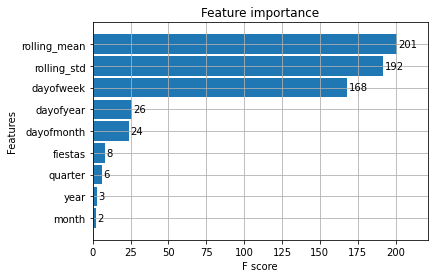

In [196]:
plot_importance(reg, height=0.9)

Notemos que las mas importantes son nuestra rolling_mean, rolling_std y **todo lo referente al día** en el que suceden las ventas!

Visualicemos los resultados del primer mes en nuestro Test:

In [197]:
df_test['Prediction'] = reg.predict(X_test)
df_all = pd.concat([df_test, df_training], sort=False)

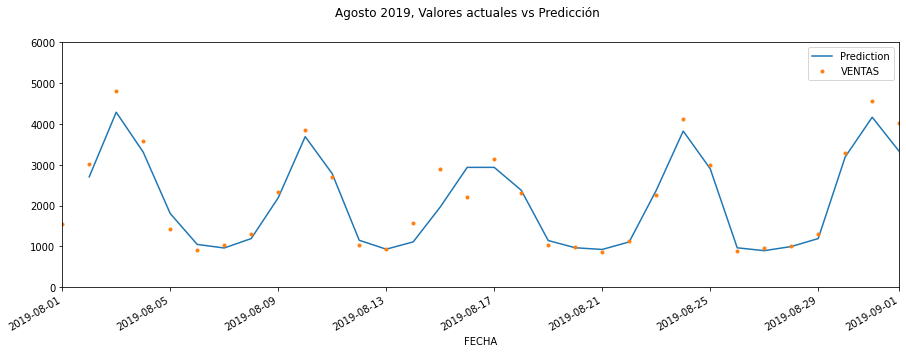

In [198]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
_ = df_all[['Prediction','VENTAS']].plot(ax=ax,
                                              style=['-','.'])
ax.set_xbound(lower='08-01-2019', upper='09-01-2019')
ax.set_ylim(0, 6000)
plot = plt.suptitle('Agosto 2019, Valores actuales vs Predicción')

A simple vista, nuestro modelo como está **se ve lo suficientemente bien** al menos para estas fechas, seamos un poco mas rigurosos implementando algunas métricas.

###**Midamos el desempeño de nuestro modelo**

Usaremos tres métricas relevantes para nuestro problema:

- MSE: Hace referencia a la media cuadrática del error
- MAE: Es la media absoluta del error
- MAPE: El la media absoluta porcentual del error

####**MSE**

In [199]:
mean_squared_error(y_true=df_test['VENTAS'],
                   y_pred=df_test['Prediction'])

314917.26990045706

####**MAE**

In [200]:
mean_absolute_error(y_true=df_test['VENTAS'],
                   y_pred=df_test['Prediction'])

286.3822070432449

####**MAPE**

In [201]:
def mean_absolute_percentage_error(y_true, y_pred): 
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
mean_absolute_percentage_error(y_true=df_test['VENTAS'],
                   y_pred=df_test['Prediction'])

11.294005387507204

In [202]:
df_test['error'] = df_test['VENTAS'] - df_test['Prediction']
df_test['abs_error'] = df_test['error'].apply(np.abs)
error_by_day = df_test.groupby(['year','month','dayofmonth']) \
    .mean()[['VENTAS','Prediction','error','abs_error']]

Notemos que tenemos un MSE de 932452, MAE de 437 y un **MAPE de 15.6&%**. Lo más relevante a explicar aquí es que las industrias en general cuando quieren predecir su demanda tienen problemas cuando hay promociones y precios inestables debido a eventos externos como por ejemplo partidos de futbol, feriados, entre otros.

De estas métricas, la mas usada para determinar la precisión de los forecast es MAPE. No hay hay una medida de bueno y malo explicita, sin embargo por experiencia, para las **empresas con demanda mas predecible tienen un MAPE menor al 10%.** Es decir, **no estamos tan lejos.**

Cabe decir. que aunque el MSE no sea usado como métrica idonea es necesario revisarlo tambien pues en nuestro caso tenemos un MSE elevado, es decir, los valores se dispersan al rededor de su momento central(media), por lo tanto, siempre deberíamos preferir un MSE mas pequeño.

###¿Posibles causas de los resultados de nuestras métricas?

Analicemos los errores absolutos mas grandes y cuando ocurren:

In [203]:
error_by_day.sort_values('abs_error', ascending=False).head(20)

VENTAS   Prediction        error    abs_error
year month dayofmonth                                                    
2019 9     20          2283.670985  6548.953125 -4265.282140  4265.282140
           16          9632.299988  7225.816406  2406.483582  2406.483582
           14          9362.665071  7731.223633  1631.441438  1631.441438
     11    1           3767.048987  5233.626465 -1466.577478  1466.577478
     10    21          4439.019995  3271.431641  1167.588354  1167.588354
     9     17          9786.519964  8826.175781   960.344183   960.344183
     8     15          2891.000000  1964.491821   926.508179   926.508179
     11    2           2976.002021  3896.206055  -920.204033   920.204033
     10    30          3188.839017  2391.538818   797.300199   797.300199
     9     9           2087.349993  2860.323486  -772.973493   772.973493
     8     16          2222.000000  2936.832764  -714.832764   714.832764
     9     1           4036.000000  3329.377686   706.622314   706.622314
           12          4839.761989  4193.187500   646.574489   646.574489
           21          1585.745004  2232.252686  -646.507682   646.507682
     10    26          6243.631984  5615.921387   627.710597   627.710597
           22          2934.669983  3468.621582  -533.951599   533.951599
     9     11          2859.868989  2336.519775   523.349214   523.349214
     8     3           4800.000000  4288.860352   511.139648   511.139648
     9     13          5664.478996  6148.560059  -484.081063   484.081063
     11    13          1550.834990  1069.643677   481.191313   481.191313

### **Optimicemos nuestro modelo**

Utilizaremos Optuna, una librería muy buena para ajustar y tunnear hiperparámetros. 

In [204]:
import optuna

Creamos una función que usaremos para optimizar el modelo que contiene un diccionario con los parámetros a evaluar además de las variables de Train y Test pertinentes:

In [205]:

def objective(trial, data=None , target=None):

    train_x, train_y = create_features(df_training, label = 'VENTAS')
    test_x, test_y = create_features(df_test, label='VENTAS')
    param = {
        'lambda': trial.suggest_loguniform('lambda', 1e-3, 10.0),
        'alpha': trial.suggest_loguniform('alpha', 1e-3, 10.0),
        'colsample_bytree': trial.suggest_categorical('colsample_bytree', [0.3,0.4,0.5,0.6,0.7,0.8,0.9, 1.0]),
        'subsample': trial.suggest_categorical('subsample', [0.4,0.5,0.6,0.7,0.8,1.0]),
        'learning_rate': trial.suggest_categorical('learning_rate', [0.008,0.009,0.01,0.012,0.014,0.016,0.018, 0.02]),
        'n_estimators': 1000,
        'max_depth': trial.suggest_categorical('max_depth', [5,7,9,11,13,15,17,20]),
        'random_state': trial.suggest_categorical('random_state', [24, 48,2020]),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 300),
    }
    model = xgb.XGBRegressor(**param)  
    
    model.fit(train_x,train_y,eval_set=[(test_x,test_y)],early_stopping_rounds=100,verbose=False)
    
    preds = model.predict(test_x)
    
    rmse = mean_squared_error(test_y, preds,squared=False)
    
    return rmse

Aquí empezamos la optimización entregada por Optuna mediante el método de Grid-Search

In [206]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)

[I 2022-03-06 06:35:43,475] A new study created in memory with name: no-name-8367ffd2-9190-43f2-9a2b-df81b02cb81a
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: FutureWarning:

Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.



[06:35:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2022-03-06 06:35:45,328] Trial 0 finished with value: 723.4884943693645 and parameters: {'lambda': 0.007646949682309666, 'alpha': 0.0032410419713830153, 'colsample_bytree': 0.7, 'subsample': 0.5, 'learning_rate': 0.009, 'max_depth': 7, 'random_state': 24, 'min_child_weight': 17}. Best is trial 0 with value: 723.4884943693645.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: FutureWarning:

Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.



[06:35:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2022-03-06 06:35:46,346] Trial 1 finished with value: 1536.9953751991188 and parameters: {'lambda': 0.01880624339836957, 'alpha': 0.17579874140349588, 'colsample_bytree': 0.8, 'subsample': 0.7, 'learning_rate': 0.016, 'max_depth': 20, 'random_state': 2020, 'min_child_weight': 262}. Best is trial 0 with value: 723.4884943693645.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: FutureWarning:

Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.



[06:35:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2022-03-06 06:35:48,011] Trial 2 finished with value: 783.6460794703355 and parameters: {'lambda': 0.06837744211426211, 'alpha': 0.005416361368362062, 'colsample_bytree': 0.7, 'subsample': 0.6, 'learning_rate': 0.016, 'max_depth': 15, 'random_state': 48, 'min_child_weight': 36}. Best is trial 0 with value: 723.4884943693645.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: FutureWarning:

Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.



[06:35:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2022-03-06 06:35:49,219] Trial 3 finished with value: 1078.878111201635 and parameters: {'lambda': 0.08970074515925335, 'alpha': 0.004325540763774848, 'colsample_bytree': 0.5, 'subsample': 0.8, 'learning_rate': 0.008, 'max_depth': 20, 'random_state': 24, 'min_child_weight': 131}. Best is trial 0 with value: 723.4884943693645.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: FutureWarning:

Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.



[06:35:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2022-03-06 06:35:50,361] Trial 4 finished with value: 1305.3218317142648 and parameters: {'lambda': 0.028544410885853886, 'alpha': 1.2710647487499267, 'colsample_bytree': 0.7, 'subsample': 0.5, 'learning_rate': 0.009, 'max_depth': 13, 'random_state': 2020, 'min_child_weight': 164}. Best is trial 0 with value: 723.4884943693645.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: FutureWarning:

Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.



[06:35:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2022-03-06 06:35:51,189] Trial 5 finished with value: 1395.7745507957497 and parameters: {'lambda': 0.1530727758697175, 'alpha': 0.027248112903485933, 'colsample_bytree': 1.0, 'subsample': 0.8, 'learning_rate': 0.018, 'max_depth': 15, 'random_state': 2020, 'min_child_weight': 277}. Best is trial 0 with value: 723.4884943693645.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: FutureWarning:

Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.



[06:35:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2022-03-06 06:35:52,430] Trial 6 finished with value: 1067.3999996881123 and parameters: {'lambda': 0.4904001455815051, 'alpha': 0.17369286510238227, 'colsample_bytree': 0.5, 'subsample': 0.6, 'learning_rate': 0.008, 'max_depth': 20, 'random_state': 2020, 'min_child_weight': 96}. Best is trial 0 with value: 723.4884943693645.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: FutureWarning:

Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.



[06:35:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2022-03-06 06:35:53,132] Trial 7 finished with value: 1788.585207853585 and parameters: {'lambda': 0.20630779425590504, 'alpha': 0.03423666706811264, 'colsample_bytree': 1.0, 'subsample': 0.4, 'learning_rate': 0.016, 'max_depth': 17, 'random_state': 24, 'min_child_weight': 229}. Best is trial 0 with value: 723.4884943693645.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: FutureWarning:

Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.



[06:35:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2022-03-06 06:35:54,550] Trial 8 finished with value: 851.675862949218 and parameters: {'lambda': 0.026598769002188584, 'alpha': 1.012078480664023, 'colsample_bytree': 0.5, 'subsample': 0.8, 'learning_rate': 0.009, 'max_depth': 11, 'random_state': 2020, 'min_child_weight': 55}. Best is trial 0 with value: 723.4884943693645.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: FutureWarning:

Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.



[06:35:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2022-03-06 06:35:56,038] Trial 9 finished with value: 765.763460805406 and parameters: {'lambda': 0.004047550325648545, 'alpha': 0.01623458986983771, 'colsample_bytree': 0.6, 'subsample': 0.5, 'learning_rate': 0.02, 'max_depth': 7, 'random_state': 24, 'min_child_weight': 34}. Best is trial 0 with value: 723.4884943693645.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: FutureWarning:

Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.



[06:35:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2022-03-06 06:35:57,299] Trial 10 finished with value: 1072.6205956206575 and parameters: {'lambda': 3.0621040481514386, 'alpha': 0.0010838470908401943, 'colsample_bytree': 0.9, 'subsample': 1.0, 'learning_rate': 0.014, 'max_depth': 7, 'random_state': 48, 'min_child_weight': 177}. Best is trial 0 with value: 723.4884943693645.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: FutureWarning:

Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.



[06:35:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2022-03-06 06:35:59,037] Trial 11 finished with value: 477.7349652916871 and parameters: {'lambda': 0.0011970970073810307, 'alpha': 0.006345943084816446, 'colsample_bytree': 0.6, 'subsample': 0.5, 'learning_rate': 0.02, 'max_depth': 7, 'random_state': 24, 'min_child_weight': 5}. Best is trial 11 with value: 477.7349652916871.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: FutureWarning:

Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.



[06:35:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2022-03-06 06:36:00,618] Trial 12 finished with value: 693.3627522817181 and parameters: {'lambda': 0.001121840286998538, 'alpha': 0.0022741328331851406, 'colsample_bytree': 0.3, 'subsample': 0.5, 'learning_rate': 0.01, 'max_depth': 9, 'random_state': 24, 'min_child_weight': 9}. Best is trial 11 with value: 477.7349652916871.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: FutureWarning:

Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.



[06:36:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2022-03-06 06:36:02,275] Trial 13 finished with value: 706.4767843149403 and parameters: {'lambda': 0.0010419081253060403, 'alpha': 0.0010308192309574434, 'colsample_bytree': 0.3, 'subsample': 0.5, 'learning_rate': 0.01, 'max_depth': 9, 'random_state': 24, 'min_child_weight': 1}. Best is trial 11 with value: 477.7349652916871.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: FutureWarning:

Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.



[06:36:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2022-03-06 06:36:03,539] Trial 14 finished with value: 985.2431128197899 and parameters: {'lambda': 0.0010983421701039986, 'alpha': 0.008283009302937436, 'colsample_bytree': 0.6, 'subsample': 0.5, 'learning_rate': 0.02, 'max_depth': 9, 'random_state': 24, 'min_child_weight': 79}. Best is trial 11 with value: 477.7349652916871.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: FutureWarning:

Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.



[06:36:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2022-03-06 06:36:04,607] Trial 15 finished with value: 1251.8190139851986 and parameters: {'lambda': 0.004144351248331857, 'alpha': 0.05421147231678165, 'colsample_bytree': 0.4, 'subsample': 0.4, 'learning_rate': 0.012, 'max_depth': 5, 'random_state': 24, 'min_child_weight': 110}. Best is trial 11 with value: 477.7349652916871.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: FutureWarning:

Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.



[06:36:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2022-03-06 06:36:05,891] Trial 16 finished with value: 879.0233784139973 and parameters: {'lambda': 0.002234137652874554, 'alpha': 0.0019137001535599533, 'colsample_bytree': 0.3, 'subsample': 1.0, 'learning_rate': 0.01, 'max_depth': 9, 'random_state': 24, 'min_child_weight': 61}. Best is trial 11 with value: 477.7349652916871.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: FutureWarning:

Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.



[06:36:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2022-03-06 06:36:06,963] Trial 17 finished with value: 1267.3380481768377 and parameters: {'lambda': 9.577317989812837, 'alpha': 7.67106797692486, 'colsample_bytree': 0.3, 'subsample': 0.7, 'learning_rate': 0.02, 'max_depth': 5, 'random_state': 48, 'min_child_weight': 195}. Best is trial 11 with value: 477.7349652916871.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: FutureWarning:

Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.



[06:36:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2022-03-06 06:36:09,428] Trial 18 finished with value: 526.1597739031163 and parameters: {'lambda': 0.00966191829972915, 'alpha': 0.011351592508771957, 'colsample_bytree': 0.6, 'subsample': 0.5, 'learning_rate': 0.01, 'max_depth': 13, 'random_state': 24, 'min_child_weight': 2}. Best is trial 11 with value: 477.7349652916871.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: FutureWarning:

Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.



[06:36:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2022-03-06 06:36:10,547] Trial 19 finished with value: 1241.11320471962 and parameters: {'lambda': 0.012477184864878985, 'alpha': 0.011111483578907207, 'colsample_bytree': 0.6, 'subsample': 0.5, 'learning_rate': 0.018, 'max_depth': 13, 'random_state': 24, 'min_child_weight': 137}. Best is trial 11 with value: 477.7349652916871.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: FutureWarning:

Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.



[06:36:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2022-03-06 06:36:11,831] Trial 20 finished with value: 979.5753071024926 and parameters: {'lambda': 0.005284449258832661, 'alpha': 0.07706060623107167, 'colsample_bytree': 0.6, 'subsample': 0.5, 'learning_rate': 0.014, 'max_depth': 13, 'random_state': 48, 'min_child_weight': 66}. Best is trial 11 with value: 477.7349652916871.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: FutureWarning:

Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.



[06:36:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2022-03-06 06:36:15,452] Trial 21 finished with value: 522.3789283005452 and parameters: {'lambda': 0.002070453467351353, 'alpha': 0.002477472176235693, 'colsample_bytree': 0.6, 'subsample': 0.5, 'learning_rate': 0.01, 'max_depth': 17, 'random_state': 24, 'min_child_weight': 8}. Best is trial 11 with value: 477.7349652916871.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: FutureWarning:

Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.



[06:36:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2022-03-06 06:36:17,189] Trial 22 finished with value: 814.0614392987188 and parameters: {'lambda': 0.0024824151999809363, 'alpha': 0.013518581130385725, 'colsample_bytree': 0.6, 'subsample': 0.5, 'learning_rate': 0.01, 'max_depth': 11, 'random_state': 24, 'min_child_weight': 31}. Best is trial 11 with value: 477.7349652916871.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: FutureWarning:

Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.



[06:36:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2022-03-06 06:36:18,647] Trial 23 finished with value: 857.1732369509018 and parameters: {'lambda': 0.010050377955066437, 'alpha': 0.0058057675183087794, 'colsample_bytree': 0.6, 'subsample': 0.5, 'learning_rate': 0.01, 'max_depth': 17, 'random_state': 24, 'min_child_weight': 43}. Best is trial 11 with value: 477.7349652916871.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: FutureWarning:

Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.



[06:36:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2022-03-06 06:36:21,021] Trial 24 finished with value: 577.0935551636073 and parameters: {'lambda': 0.002169934106990421, 'alpha': 0.025039719108919212, 'colsample_bytree': 0.6, 'subsample': 0.5, 'learning_rate': 0.012, 'max_depth': 17, 'random_state': 24, 'min_child_weight': 1}. Best is trial 11 with value: 477.7349652916871.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: FutureWarning:

Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.



[06:36:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2022-03-06 06:36:22,560] Trial 25 finished with value: 823.3592957083082 and parameters: {'lambda': 0.041401082936227615, 'alpha': 0.002135470384501761, 'colsample_bytree': 0.9, 'subsample': 1.0, 'learning_rate': 0.02, 'max_depth': 13, 'random_state': 24, 'min_child_weight': 89}. Best is trial 11 with value: 477.7349652916871.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: FutureWarning:

Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.



[06:36:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2022-03-06 06:36:23,926] Trial 26 finished with value: 838.041592525855 and parameters: {'lambda': 0.002115409071992866, 'alpha': 0.008819516344804601, 'colsample_bytree': 0.4, 'subsample': 0.4, 'learning_rate': 0.01, 'max_depth': 7, 'random_state': 24, 'min_child_weight': 24}. Best is trial 11 with value: 477.7349652916871.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: FutureWarning:

Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.



[06:36:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2022-03-06 06:36:25,194] Trial 27 finished with value: 1098.845347438759 and parameters: {'lambda': 0.0059170115145009234, 'alpha': 0.003312685021212074, 'colsample_bytree': 0.8, 'subsample': 0.6, 'learning_rate': 0.01, 'max_depth': 17, 'random_state': 24, 'min_child_weight': 117}. Best is trial 11 with value: 477.7349652916871.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: FutureWarning:

Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.



[06:36:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2022-03-06 06:36:26,657] Trial 28 finished with value: 779.07025308314 and parameters: {'lambda': 0.01133359707987448, 'alpha': 0.1680764166413829, 'colsample_bytree': 0.6, 'subsample': 0.7, 'learning_rate': 0.02, 'max_depth': 17, 'random_state': 24, 'min_child_weight': 52}. Best is trial 11 with value: 477.7349652916871.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: FutureWarning:

Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.



[06:36:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2022-03-06 06:36:28,358] Trial 29 finished with value: 729.2260688551178 and parameters: {'lambda': 0.8646296811476389, 'alpha': 0.003233224882635716, 'colsample_bytree': 0.6, 'subsample': 0.5, 'learning_rate': 0.01, 'max_depth': 7, 'random_state': 48, 'min_child_weight': 16}. Best is trial 11 with value: 477.7349652916871.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: FutureWarning:

Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.



[06:36:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2022-03-06 06:36:30,036] Trial 30 finished with value: 749.3943672608352 and parameters: {'lambda': 0.007035134448178026, 'alpha': 0.3912507593649216, 'colsample_bytree': 0.6, 'subsample': 0.5, 'learning_rate': 0.012, 'max_depth': 13, 'random_state': 24, 'min_child_weight': 21}. Best is trial 11 with value: 477.7349652916871.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: FutureWarning:

Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.



[06:36:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2022-03-06 06:36:32,751] Trial 31 finished with value: 517.6455873000152 and parameters: {'lambda': 0.002222466129901785, 'alpha': 0.026681781765495054, 'colsample_bytree': 0.6, 'subsample': 0.5, 'learning_rate': 0.012, 'max_depth': 17, 'random_state': 24, 'min_child_weight': 2}. Best is trial 11 with value: 477.7349652916871.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: FutureWarning:

Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.



[06:36:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2022-03-06 06:36:35,312] Trial 32 finished with value: 514.3461496366431 and parameters: {'lambda': 0.0028710344390608087, 'alpha': 0.017948102363608515, 'colsample_bytree': 0.6, 'subsample': 0.5, 'learning_rate': 0.012, 'max_depth': 17, 'random_state': 24, 'min_child_weight': 3}. Best is trial 11 with value: 477.7349652916871.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: FutureWarning:

Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.



[06:36:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2022-03-06 06:36:36,785] Trial 33 finished with value: 817.9818096577048 and parameters: {'lambda': 0.0026907922864437637, 'alpha': 0.04801498790816014, 'colsample_bytree': 0.6, 'subsample': 0.5, 'learning_rate': 0.012, 'max_depth': 17, 'random_state': 24, 'min_child_weight': 37}. Best is trial 11 with value: 477.7349652916871.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: FutureWarning:

Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.



[06:36:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2022-03-06 06:36:38,275] Trial 34 finished with value: 885.4780728465932 and parameters: {'lambda': 0.0017979228179816954, 'alpha': 0.018651221510981864, 'colsample_bytree': 0.8, 'subsample': 0.7, 'learning_rate': 0.012, 'max_depth': 17, 'random_state': 24, 'min_child_weight': 74}. Best is trial 11 with value: 477.7349652916871.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: FutureWarning:

Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.



[06:36:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2022-03-06 06:36:39,980] Trial 35 finished with value: 749.3943672608352 and parameters: {'lambda': 0.003948061935988125, 'alpha': 0.005570617545284665, 'colsample_bytree': 0.6, 'subsample': 0.5, 'learning_rate': 0.012, 'max_depth': 17, 'random_state': 24, 'min_child_weight': 21}. Best is trial 11 with value: 477.7349652916871.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: FutureWarning:

Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.



[06:36:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2022-03-06 06:36:41,633] Trial 36 finished with value: 801.0310026402175 and parameters: {'lambda': 0.019629622148381286, 'alpha': 0.10915943104519865, 'colsample_bytree': 0.7, 'subsample': 0.8, 'learning_rate': 0.012, 'max_depth': 15, 'random_state': 2020, 'min_child_weight': 48}. Best is trial 11 with value: 477.7349652916871.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: FutureWarning:

Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.



[06:36:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2022-03-06 06:36:43,954] Trial 37 finished with value: 671.2025846603182 and parameters: {'lambda': 0.0014518031053431938, 'alpha': 0.006290598786791908, 'colsample_bytree': 1.0, 'subsample': 0.6, 'learning_rate': 0.008, 'max_depth': 17, 'random_state': 24, 'min_child_weight': 18}. Best is trial 11 with value: 477.7349652916871.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: FutureWarning:

Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.



[06:36:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2022-03-06 06:36:45,579] Trial 38 finished with value: 790.2287272514619 and parameters: {'lambda': 0.0036461805793204854, 'alpha': 0.0368321619435676, 'colsample_bytree': 0.7, 'subsample': 0.5, 'learning_rate': 0.016, 'max_depth': 20, 'random_state': 2020, 'min_child_weight': 31}. Best is trial 11 with value: 477.7349652916871.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: FutureWarning:

Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.



[06:36:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2022-03-06 06:36:46,895] Trial 39 finished with value: 929.4750702557768 and parameters: {'lambda': 0.0016675149958418347, 'alpha': 0.021513550113539462, 'colsample_bytree': 0.5, 'subsample': 0.5, 'learning_rate': 0.009, 'max_depth': 7, 'random_state': 48, 'min_child_weight': 49}. Best is trial 11 with value: 477.7349652916871.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: FutureWarning:

Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.



[06:36:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2022-03-06 06:36:47,966] Trial 40 finished with value: 1247.326131397298 and parameters: {'lambda': 0.051591956648962434, 'alpha': 0.36646387495322624, 'colsample_bytree': 0.4, 'subsample': 0.8, 'learning_rate': 0.018, 'max_depth': 17, 'random_state': 24, 'min_child_weight': 210}. Best is trial 11 with value: 477.7349652916871.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: FutureWarning:

Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.



[06:36:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2022-03-06 06:36:50,188] Trial 41 finished with value: 576.3305474883255 and parameters: {'lambda': 0.008450037411077142, 'alpha': 0.010837163264291887, 'colsample_bytree': 0.6, 'subsample': 0.5, 'learning_rate': 0.012, 'max_depth': 15, 'random_state': 24, 'min_child_weight': 1}. Best is trial 11 with value: 477.7349652916871.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: FutureWarning:

Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.



[06:36:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2022-03-06 06:36:52,174] Trial 42 finished with value: 587.1281949798189 and parameters: {'lambda': 0.0161927312105895, 'alpha': 0.0037665764360955097, 'colsample_bytree': 0.6, 'subsample': 0.5, 'learning_rate': 0.008, 'max_depth': 11, 'random_state': 24, 'min_child_weight': 10}. Best is trial 11 with value: 477.7349652916871.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: FutureWarning:

Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.



[06:36:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2022-03-06 06:36:52,839] Trial 43 finished with value: 1789.6864223263947 and parameters: {'lambda': 0.0033025661039909776, 'alpha': 0.0016923402738063288, 'colsample_bytree': 0.6, 'subsample': 0.5, 'learning_rate': 0.014, 'max_depth': 13, 'random_state': 24, 'min_child_weight': 236}. Best is trial 11 with value: 477.7349652916871.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: FutureWarning:

Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.



[06:36:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2022-03-06 06:36:54,957] Trial 44 finished with value: 633.3121272614965 and parameters: {'lambda': 0.10866772014851382, 'alpha': 0.016510669328606956, 'colsample_bytree': 0.9, 'subsample': 0.4, 'learning_rate': 0.016, 'max_depth': 20, 'random_state': 2020, 'min_child_weight': 12}. Best is trial 11 with value: 477.7349652916871.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: FutureWarning:

Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.



[06:36:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2022-03-06 06:36:56,700] Trial 45 finished with value: 765.6417548169906 and parameters: {'lambda': 0.005592357522146009, 'alpha': 0.03680935380465586, 'colsample_bytree': 1.0, 'subsample': 0.5, 'learning_rate': 0.02, 'max_depth': 7, 'random_state': 24, 'min_child_weight': 36}. Best is trial 11 with value: 477.7349652916871.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: FutureWarning:

Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.



[06:36:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2022-03-06 06:36:57,614] Trial 46 finished with value: 1790.4900003146174 and parameters: {'lambda': 0.0010399249852815257, 'alpha': 0.004313160969946363, 'colsample_bytree': 0.6, 'subsample': 0.5, 'learning_rate': 0.009, 'max_depth': 17, 'random_state': 24, 'min_child_weight': 283}. Best is trial 11 with value: 477.7349652916871.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: FutureWarning:

Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.



[06:36:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2022-03-06 06:36:58,685] Trial 47 finished with value: 1790.8228549129508 and parameters: {'lambda': 0.0015590025735371905, 'alpha': 0.00698500170499336, 'colsample_bytree': 0.6, 'subsample': 0.6, 'learning_rate': 0.01, 'max_depth': 5, 'random_state': 24, 'min_child_weight': 300}. Best is trial 11 with value: 477.7349652916871.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: FutureWarning:

Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.



[06:36:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2022-03-06 06:36:59,964] Trial 48 finished with value: 1038.560904927414 and parameters: {'lambda': 0.002963836717270177, 'alpha': 0.0012702976586827066, 'colsample_bytree': 0.8, 'subsample': 1.0, 'learning_rate': 0.012, 'max_depth': 17, 'random_state': 24, 'min_child_weight': 158}. Best is trial 11 with value: 477.7349652916871.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: FutureWarning:

Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.



[06:37:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2022-03-06 06:37:01,486] Trial 49 finished with value: 762.6144073347393 and parameters: {'lambda': 0.02203334607838758, 'alpha': 0.07839459307734487, 'colsample_bytree': 0.5, 'subsample': 0.5, 'learning_rate': 0.018, 'max_depth': 7, 'random_state': 2020, 'min_child_weight': 26}. Best is trial 11 with value: 477.7349652916871.


Number of finished trials: 50
Best trial: {'lambda': 0.0011970970073810307, 'alpha': 0.006345943084816446, 'colsample_bytree': 0.6, 'subsample': 0.5, 'learning_rate': 0.02, 'max_depth': 7, 'random_state': 24, 'min_child_weight': 5}


Los mejores parámetros según nuestro optimizador

In [207]:
study.best_params

{'alpha': 0.006345943084816446,
 'colsample_bytree': 0.6,
 'lambda': 0.0011970970073810307,
 'learning_rate': 0.02,
 'max_depth': 7,
 'min_child_weight': 5,
 'random_state': 24,
 'subsample': 0.5}

Entrenamos el modelo con nuestros nuevos parámetros:

In [208]:
best_params = study.best_params
best_params['n_estimators']=4000

reg_opt = xgb.XGBRegressor(**(best_params))

reg_opt.fit(X_train, y_train,eval_set=[(X_train, y_train), (X_test, y_test)],
        early_stopping_rounds=50,
       verbose=False)

[06:37:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(alpha=0.006345943084816446, colsample_bytree=0.6,
             lambda=0.0011970970073810307, learning_rate=0.02, max_depth=7,
             min_child_weight=5, n_estimators=4000, random_state=24,
             subsample=0.5)

#### **Evaluación del Modelo dados nuestros nuevos parámetros**

In [209]:
df_test_opt = df_test.copy()
df_test_opt['Prediction'] = reg_opt.predict(X_test)
df_all = pd.concat([df_test, df_training], sort=False)

In [210]:
df_test_opt['error'] = df_test_opt['VENTAS'] - df_test_opt['Prediction']
df_test_opt['abs_error'] = df_test_opt['error'].apply(np.abs)
error_by_day = df_test.groupby(['year','month','dayofmonth']) \
    .mean()[['VENTAS','Prediction','error','abs_error']]

#### **MAPE**

In [211]:
mean_absolute_percentage_error(y_true=df_test_opt['VENTAS'],
                   y_pred=df_test_opt['Prediction'])

9.278681699313445

#### **MAE**

In [212]:
mean_absolute_error(y_true=df_test_opt['VENTAS'],
                   y_pred=df_test_opt['Prediction'])

236.4812625678522

#### **MSE**

In [213]:
mean_squared_error(y_true=df_test_opt['VENTAS'],
                   y_pred=df_test_opt['Prediction'])

231976.0364223796

 - Dato extra, nuestro R2 aumentó considerablemente con la optimización de parámetros:

 Antes:

In [214]:
print(r2_score(df_test['VENTAS'],df_test['Prediction']))

0.8982558130277674


Ahora:

In [215]:

print(r2_score(df_test_opt['VENTAS'],df_test_opt['Prediction']))

0.9250526551614762


Es decir, aumentó en un 0.12.

Ahora bien, podemos notar que si bien nuestro **MAPE se acerca mas al deseado 10%**, no aumentó tanto, sin embargo, **nuestro MSE se redujo bastante lo que es bueno.**

Sin embargo, esta no es la única forma de optimizar nuestro modelo. Hay más técnicas que podríamos implementar para lograr quizá mejores resultados sin mencionar que podríamos aplicar una mejor ingeniería de variables.

Sólo a modo de MVP usarémos este modelo, recordando que hay maneras de mejorar nuestras predicciones.


### **Predicción para la las fechas 14-12-2019 al 27-12-2019:**

In [222]:
test = pd.read_excel('predempty.xlsx', parse_dates=[0], index_col=[0])
pred_x, pred_y = create_features(test, label='VENTAS')
test['Prediction'] = reg_opt.predict(pred_x)
test.drop(['VENTAS','dayofweek', 'quarter', 'month', 'year', 'dayofyear',
 'dayofmonth', 'weekofyear', 'date','rolling_mean', 'rolling_std', 'fiestas'], axis=1, inplace=True)
test.head(14)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: FutureWarning:

Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.



,Prediction
FECHA,
2020-01-14,2133.338867
2020-01-15,2198.349854
2020-01-16,2466.680176
2020-01-17,3596.022705
2020-01-18,3858.083740
2020-01-19,2749.697266
2020-01-20,2001.847412
2020-01-21,1983.982788
2020-01-22,2019.173462


In [223]:
test.sum()

Prediction    35467.050781
dtype: float32

In [221]:
df_training[(df_training['month']==12) & (df_training['year']==2017) & (df_training['dayofmonth']>=14) & (df_training['dayofmonth']<=27) ].VENTAS.sum()

46032.0

### **Rápida implementación de FBprophet:**



### **Revisemos su Estacionariedad**

Se dice que una serie de tiempo es estacionaria cuando su distribución y sus parámetros no varían con el tiempo. En términos más concretos, la media y la varianza de una serie estacionaria no cambian con el tiempo, y tampoco siguen una tendencia.

Una serie estacionaria es mucho más fácil de predecir. Si se comportaba de una manera en el pasado ( digamos con una determinada media y varianza), podremos suponer que se seguirá comportando de la misma forma en el futuro. Además las teorías que se basan en series estacionarias son mas fáciles de implementar.

Hay multples formas de determinar si una serie es estacionaria o no, en particular usaremos el **Test de Dickey-Fuller con un intervalo de confianza del 99%.**

In [19]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries, window = 12, cutoff = 0.01):

    # Calculamos la media móvil y la desviación móvil
    rolmean = timeseries.rolling(window).mean()
    rolstd = timeseries.rolling(window).std()

    #Graficamos
    fig = plt.figure(figsize=(12, 8))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Media Movil')
    std = plt.plot(rolstd, color='black', label = 'Std Movil')
    plt.legend(loc='best')
    plt.title('Media & Desviación Std Movil')
    plt.show()
    
    #Dickey-Fuller test:
    print('Resultados del test Dickey-Fuller:')
    dftest = adfuller(timeseries, autolag='AIC', maxlag = 20 )
    dfoutput = pd.Series(dftest[0:4], index=['Test Estadistico','p-value','#Lags usados','Nro. de Observaciones'])
    for key,value in dftest[4].items():
        dfoutput['Valor Crítico (%s)'%key] = value
    pvalue = dftest[1]
    if pvalue < cutoff:
        print('p-value = %.4f. Es probable que la serie sea Estacionaria.' % pvalue)
    else:
        print('p-value = %.4f. Es probable que la serie sea no Estacionaria.' % pvalue)
    
    print(dfoutput)

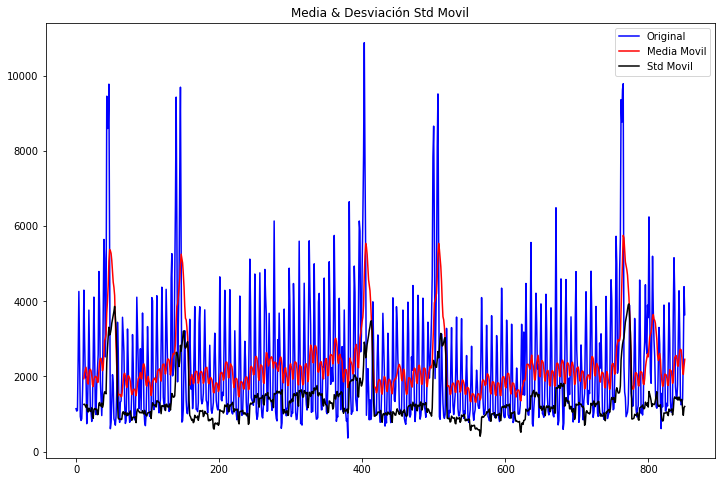

Resultados del test Dickey-Fuller:
p-value = 0.0000. Es probable que la serie sea Estacionaria.
Test Estadistico        -5.837514e+00
p-value                  3.845512e-07
#Lags usados             1.900000e+01
Nro. de Observaciones    8.320000e+02
Valor Crítico (1%)      -3.438234e+00
Valor Crítico (5%)      -2.865020e+00
Valor Crítico (10%)     -2.568623e+00
dtype: float64


In [20]:
test_stationarity(df['VENTAS'])

Mientras mas pequeño su p-value mas probable es que sea estacionaria. En este caso tenemos un muy buen p-value por lo que podríamos asumir que **en efecto es estacionaria**. En caso de que no lo fuera podemos usar varias herramientas como diferenciación y aplicar log. 

In [32]:
df_ts = df.copy()
df_ts = df_ts.set_index('FECHA')


### **ACF y PACF**

- ACF: Una serie de tiempo tiene componentes como tendencias, estacionalidad y residuos. Esta funcion considera todos estos componentes y encuentra correlaciones entre estos.

- PACF: Aquí se encuentra la correlacion de los residuos, esto quiere decir, los efectos que quedan luego de quitar los efectos de los lags anteriores.


/usr/local/lib/python3.7/dist-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


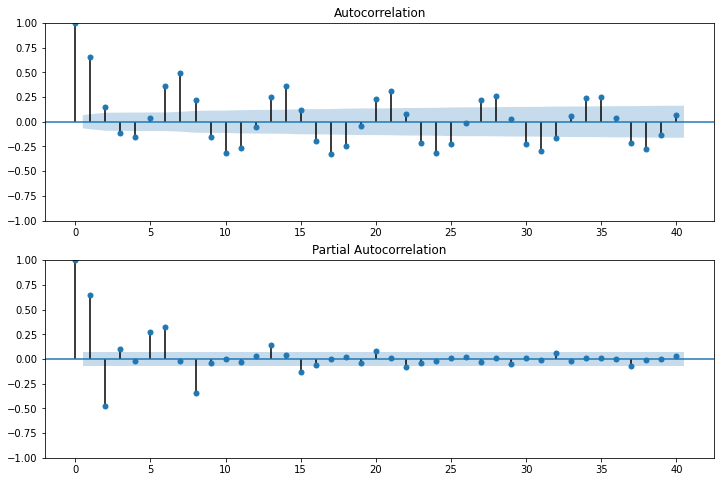

In [34]:
import statsmodels.api as sm

fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df_ts, lags=40, ax=ax1) 
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df_ts, lags=40, ax=ax2)

**Nuestras ACF y PACF muestran algún patrón**, sin embargo, para este caso en el que usarémos FBprophet no entraremos en detalle de como utilizarlos para generar nuestro modelo.

## **¡Comenzamos con nuestro Prophet!**

Importamos las librerías atingentes:

In [62]:
from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics

Creamos nuestro set de datos:

In [68]:
train_test = df.copy()
train_test = train_test.rename(columns = {'FECHA':'ds', 'VENTAS':'y'})
train_test['cap'] = 8000
train_test['floor'] = 0

In [71]:
test_size = int(train_test.shape[0] / 10)
train_df = train_test.iloc[:-test_size, :]
val_df = train_test.iloc[-test_size:int(-test_size/2), :]
test_df = train_test.iloc[int(-test_size/2):, :]

Ahora definimos una función para optimizar nuestros parámetros:

In [91]:
def objective(trial):
    params = {
        'changepoint_prior_scale': trial.suggest_float('changepoint_prior_scale', 0.005, 5),
        'changepoint_range': trial.suggest_float('changepoint_range', 0.8, 0.9),
        'seasonality_prior_scale': trial.suggest_float('seasonality_prior_scale', 0.1, 10),
        'holidays_prior_scale': trial.suggest_float('holidays_prior_scale', 0.1, 10),
        'seasonality_mode': trial.suggest_categorical('seasonality_mode', ['multiplicative', 'additive']),
        'growth': trial.suggest_categorical('growth', ['linear', 'logistic']),
        'weekly_seasonality': trial.suggest_int('weekly_seasonality', 5, 10),
        'yearly_seasonality': trial.suggest_int('yearly_seasonality', 1, 20)
    }
    
    m = Prophet(**params)
    m.add_country_holidays(country_name='CL')
    m.fit(train_df)
    preds = m.predict(val_df[['ds', 'cap', 'floor']])
    
    mae_score = mean_absolute_error(val_df['y'], preds['yhat'])
    return mae_score

In [ ]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=1000)
study.best_params

[I 2022-03-06 19:45:37,837] A new study created in memory with name: no-name-6f6af07f-94e0-4320-97e6-8667779dc9f7
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
[I 2022-03-06 19:45:41,040] Trial 0 finished with value: 1229.5093373137768 and parameters: {'changepoint_prior_scale': 4.9241560003826494, 'changepoint_range': 0.880997927591962, 'seasonality_prior_scale': 9.22425954260387, 'holidays_prior_scale': 1.2274930438277574, 'seasonality_mode': 'multiplicative', 'growth': 'logistic', 'weekly_seasonality': 6, 'yearly_seasonality': 16}. Best is trial 0 with value: 1229.5093373137768.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
[I 2022-03-06 19:45:44,014] Trial 1 finished with value: 1207.379589213728 and parameters: {'changepoint_prior_scale': 3.045676510839672, 'changepoint_range': 0.895841361373271, 'seasonality_prior_scale': 3.3646441255361164, 'holidays_prior_scale': 8.30

{'changepoint_prior_scale': 1.8835603818679296,
 'changepoint_range': 0.8262081779708362,
 'growth': 'linear',
 'holidays_prior_scale': 6.677336339012402,
 'seasonality_mode': 'additive',
 'seasonality_prior_scale': 3.9758400995535625,
 'weekly_seasonality': 5,
 'yearly_seasonality': 20}

Esta vez no nos funcionará muy bien esta optimización por lo que no la usaremos por el momento.

Función para reportar nuestros resultados obtenidos de las métricas relevantes

In [72]:
def regression_report(y_true, y_pred):
    mae_score = mean_absolute_error(y_true, y_pred)
    mse_score = mean_squared_error(y_true, y_pred)
    R2_score = r2_score(y_true, y_pred)
    
    report_dict = {
        'mae_score': mae_score,
        'mse_score': mse_score,
        'r2_score': R2_score
    }
    
    return report_dict

Generamos la predicción:

In [88]:
m = Prophet()
m.add_country_holidays(country_name='CL')

concat_train_df = pd.concat([train_df, val_df])
m.fit(concat_train_df)
preds = m.predict(test_df[['ds', 'cap', 'floor']])
result = regression_report(test_df['y'], preds['yhat'])

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Evaluamos nuestra predicción:

In [89]:
result

{'mae_score': 360.1822069888503,
 'mse_score': 248284.2648693058,
 'r2_score': 0.8179989056657344}

In [ ]:
rms = mean_squared_error(test_df['y'], preds['yhat'], squared=False)
rms

498.2813109773492

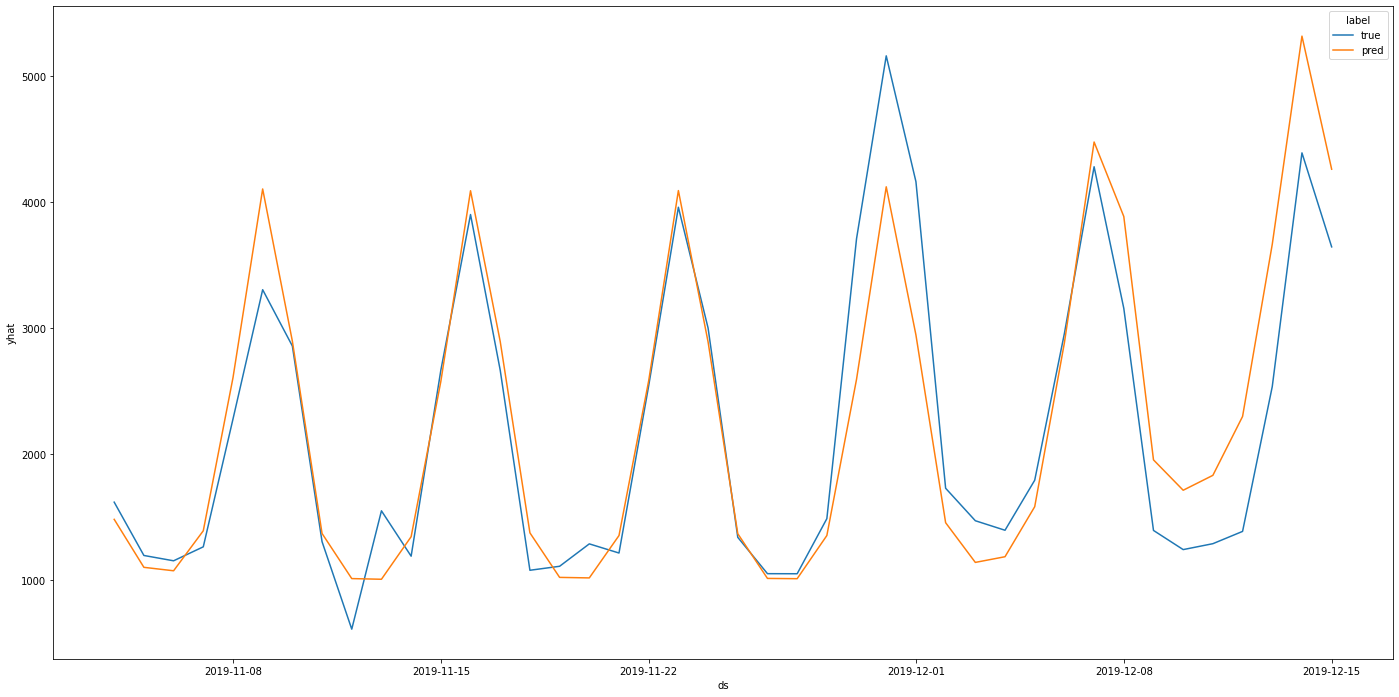

In [77]:
pd.options.mode.chained_assignment = None
test_df.loc[:, 'label'] = 'true'
test_df.loc[:, 'yhat'] = test_df.loc[:, 'y']
preds.loc[:, 'label'] = 'pred'
df_result = pd.concat([test_df[['yhat', 'label', 'ds']], preds[['yhat', 'label', 'ds']]])
fig, ax = plt.subplots(figsize=(24, 12))
sns.lineplot(y='yhat', x='ds', ax=ax, data=df_result, hue='label', markers=True)
plt.show()

In [79]:
fut_pred = pd.read_excel('predempty12.xlsx')
future_date = pd.DataFrame({'ds':list(fut_pred.FECHA)})
forecast = m.predict(future_date)

In [83]:
forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,Asunción de la Virgen [Assumption of Mary],Asunción de la Virgen [Assumption of Mary]_lower,Asunción de la Virgen [Assumption of Mary]_upper,Año Nuevo [New Year's Day],...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2019-12-14,2421.874138,4125.866403,6522.013644,2418.943892,2424.673625,0.0,0.0,0.0,0.0,...,2044.280184,2044.280184,2044.280184,848.402608,848.402608,848.402608,0.0,0.0,0.0,5314.556930
1,2019-12-15,2422.724733,3050.200185,5428.086803,2419.677115,2425.619641,0.0,0.0,0.0,0.0,...,846.545455,846.545455,846.545455,990.116419,990.116419,990.116419,0.0,0.0,0.0,4259.386607
2,2019-12-16,2423.575328,1667.653532,4156.141079,2420.393458,2426.630056,0.0,0.0,0.0,0.0,...,-672.462722,-672.462722,-672.462722,1131.664870,1131.664870,1131.664870,0.0,0.0,0.0,2882.777476
3,2019-12-17,2424.425922,1435.528882,3922.295642,2421.065910,2427.664476,0.0,0.0,0.0,0.0,...,-1026.904449,-1026.904449,-1026.904449,1270.629693,1270.629693,1270.629693,0.0,0.0,0.0,2668.151167
4,2019-12-18,2425.276517,1570.642542,4050.012724,2421.747282,2428.659738,0.0,0.0,0.0,0.0,...,-1031.281464,-1031.281464,-1031.281464,1404.505784,1404.505784,1404.505784,0.0,0.0,0.0,2798.500837
5,2019-12-19,2426.127112,2130.089917,4466.935475,2422.457395,2429.709094,0.0,0.0,0.0,0.0,...,-694.588169,-694.588169,-694.588169,1530.759174,1530.759174,1530.759174,0.0,0.0,0.0,3262.298117
6,2019-12-20,2426.977707,3433.832196,5818.520927,2423.092891,2430.715122,0.0,0.0,0.0,0.0,...,534.411164,534.411164,534.411164,1646.887698,1646.887698,1646.887698,0.0,0.0,0.0,4608.276569
7,2019-12-21,2427.828302,4991.509299,7512.779720,2423.768661,2431.714293,0.0,0.0,0.0,0.0,...,2044.280184,2044.280184,2044.280184,1750.482728,1750.482728,1750.482728,0.0,0.0,0.0,6222.591214
8,2019-12-22,2428.678896,3899.849838,6347.830161,2424.460457,2432.705748,0.0,0.0,0.0,0.0,...,846.545455,846.545455,846.545455,1839.290269,1839.290269,1839.290269,0.0,0.0,0.0,5114.514620
9,2019-12-23,2429.529491,2510.654877,4853.619747,2425.063071,2433.656382,0.0,0.0,0.0,0.0,...,-672.462722,-672.462722,-672.462722,1911.269737,1911.269737,1911.269737,0.0,0.0,0.0,3668.336507


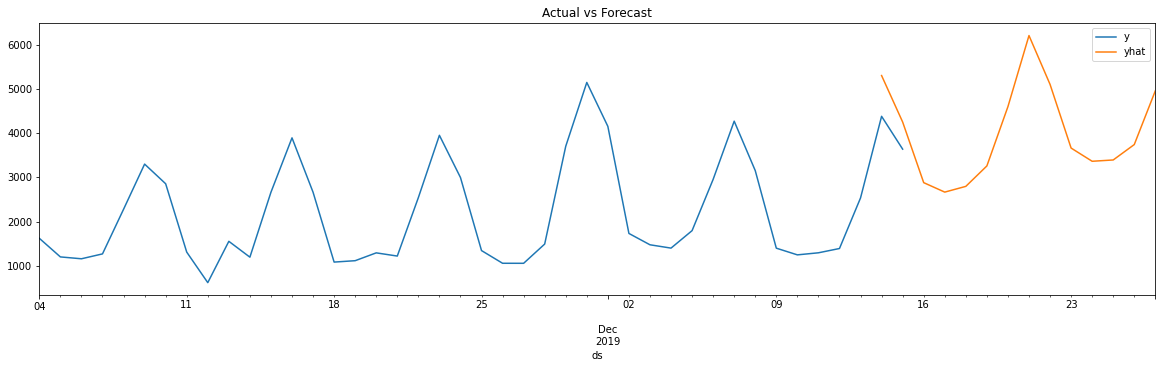

In [84]:
ax = (test_df.plot(x='ds',y='y',figsize=(20,5),title='Actual Vs Forecast'))
forecast.plot(x='ds',y='yhat',figsize=(20,5),title='Actual vs Forecast', ax=ax)

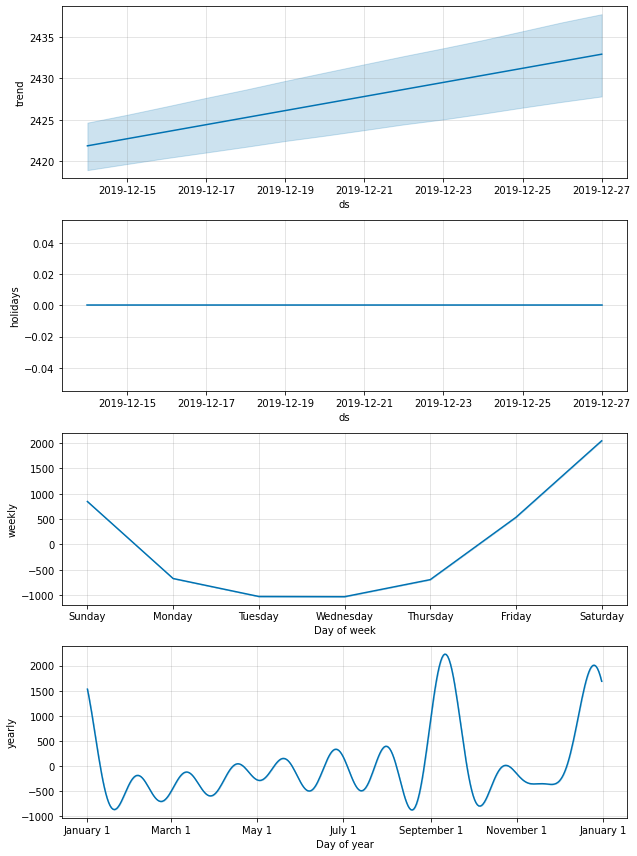

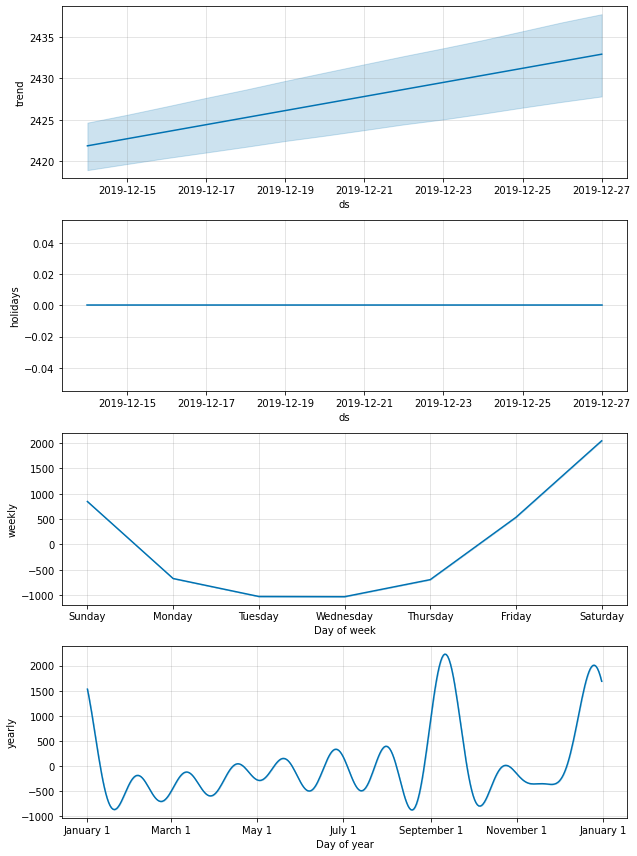

In [90]:
m.plot_components(forecast)

Finalmente, considero que debemos usar la predicción de Prophet frente a la predicción de XGBoost pues, aunque XGBoost tiene mejor Score en todo no capta muy bien la tendenciia, en cambio, con Prophet tenemos una predicción bastante cercana en comparación a los años anteriores, por lo tanto, esta sería nuestra elección.

### **Predicción final**

In [93]:
forecast[['ds','yhat']]

,ds,yhat
0,2019-12-14,5314.556930
1,2019-12-15,4259.386607
2,2019-12-16,2882.777476
3,2019-12-17,2668.151167
4,2019-12-18,2798.500837
5,2019-12-19,3262.298117
6,2019-12-20,4608.276569
7,2019-12-21,6222.591214
8,2019-12-22,5114.514620
9,2019-12-23,3668.336507


##**Conclusión del MVP**

Tenemos espacio para mejoras, por ejemplo, podemos agregarle valor a nuestro modelo generado con Prophet agregando a mano nuestras temporadas especiales, ya sea ajustar nuestros feriados, agregar días de promociones, agregar fechas de partidos de futbol y/o otras actividades relevantes para la predicción de nuestra demanda. 

In [ ]:
## Metodología de Implementación:

